In [1]:
# Import libraries
import jax
from jax import grad, vmap, random, jit
import jax.numpy as jnp
from jax.example_libraries import optimizers
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD, Adam

In [127]:
# Create dataset using two points and x test set for plotting
x_train = jnp.linspace(0,1,2).reshape(-1,1)
y_train = 1-2*x_train

x_test = jnp.linspace(-2,3,100).reshape(-1,1)

In [138]:
# Define NN to be used

sig_w = jnp.sqrt(1.5)
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=sig_w, b_std=0.5), stax.ElementwiseNumerical(jnp.tanh, deg=100),
    stax.Dense(512, W_std=sig_w, b_std=0.5), stax.ElementwiseNumerical(jnp.tanh, deg=100),
    stax.Dense(512, W_std=sig_w, b_std=0.5), stax.ElementwiseNumerical(jnp.tanh, deg=100),
    stax.Dense(1, W_std=sig_w, b_std=1)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

In [139]:
# Plot prior distributions on data

priors = []

key = random.key(42)
for _ in range(100):
    key, pri_key = random.split(key, 2)
    _, params = init_fn(pri_key, (-1,1))
    priors += [apply_fn(params, x_test)]
priors = jnp.array(priors)

In [140]:
# Use NTK to get errors in initialisation
kernel = kernel_fn(x_test, x_test, 'ntk')
std_dev = jnp.sqrt(jnp.diag(kernel))

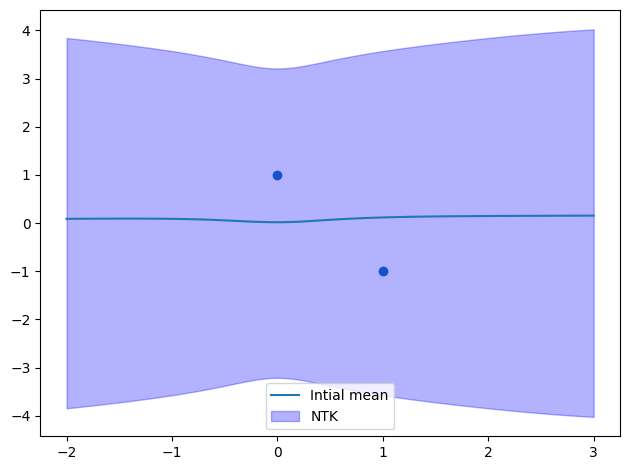

In [141]:
# Plot results thus far
plt.scatter(x_train[jnp.array([0,-1])], y_train[jnp.array([0,-1])])
plt.plot(x_test, jnp.mean(priors, axis=0), label="Intial mean")
plt.fill_between(x_test.reshape(-1), -2*std_dev, 2*std_dev, color='b', alpha=0.3, label="NTK")
plt.legend()
plt.tight_layout()
plt.show()

In [142]:
# Create predictor for data
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, x_train, y_train, learning_rate=1)

ts = jnp.array([16, 256, 65536])

ntk_means, ntk_covs = predict_fn(t=ts, x_test=x_test, get='ntk', compute_cov=True)
nngp_mean, nngp_cov = predict_fn(t=ts[-1], x_test=x_test, get='nngp', compute_cov=True)
print(ntk_means.shape, ntk_covs.shape)


(3, 100, 1) (3, 100, 100)


In [143]:
print(ntk_means[0][0][0])

1.4788455


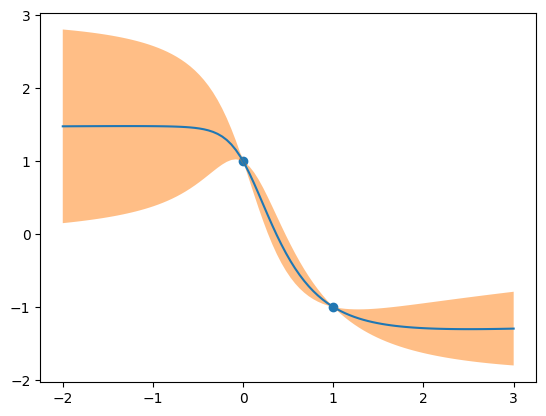

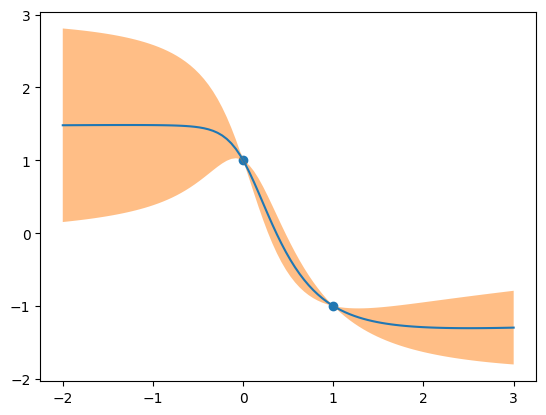

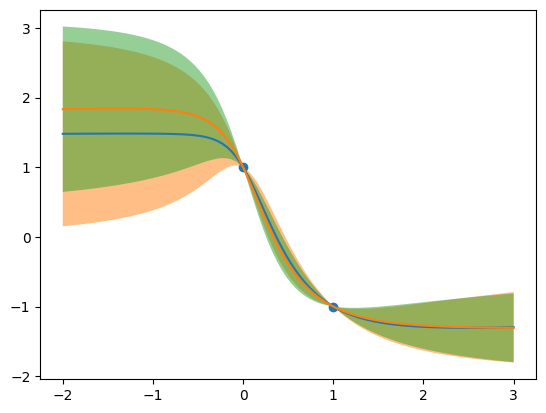

In [144]:
for i in range(len(ntk_covs)):
    plt.plot(x_test, ntk_means[i])
    plt.scatter(x_train[jnp.array([0,-1])], y_train[jnp.array([0,-1])])
    plt.fill_between(x_test.reshape(-1), (ntk_means[i].reshape(-1)-2*np.sqrt(np.diag(ntk_covs[i]))), (ntk_means[i].reshape(-1)+2*np.sqrt(np.diag(ntk_covs[i]))), alpha=0.5)
    if i == len(ntk_covs)-1:
        plt.plot(x_test, nngp_mean)
        plt.fill_between(x_test.reshape(-1), (nngp_mean.reshape(-1)-2*np.sqrt(np.diag(nngp_cov))), (nngp_mean.reshape(-1)+2*np.sqrt(np.diag(nngp_cov))), alpha=0.5)
    plt.show()

In [9]:
# Try using TensorFlow
fig2_model = Sequential([
    Input(shape=(1,)),
    Dense(units=512, activation='tanh'),
    Dense(units=512, activation='tanh'),
    Dense(units=512, activation='tanh'),
    Dense(units=1, activation='linear')
])

# Figure 1
Trying to reproduce Figure 1 using TensorFlow and JAX.

In [51]:
# Import libraries
import jax
from jax import grad, vmap, random, jit
import jax.numpy as jnp
from jax.example_libraries import optimizers
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist

seed=36

In [52]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # Normalise data

# Use a smaller batch of 128 data points, selected randomly
choices = random.choice(random.key(seed=seed), jnp.arange(len(x_train)), (128,)) 
x_train_sub, y_train_sub = x_train[choices], y_train[choices]
x_train_sub = x_train_sub.reshape((-1, 784))

In [67]:
# Define some hyperparameters
learning_rate = 0.01
layer_size = 128
num_classes = 10
epochs=2**10
layers = [784, layer_size, layer_size, layer_size, num_classes]

In [68]:
def random_layer_params(m, n, key, scale=1e-2):
    """
    Initialise the weights for a layer of a neural network.

    Args:
    m: int, the number of input units
    n: int, the number of output units
    key: PRNGKey, a key for random number generation
    scale: float, a scaling factor for the weights

    Returns:
    w: array of shape (n, m), the weights
    b: array of shape (n,), the biases

    """
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_network_params(sizes, key):
    """
    Initialise the weights for a neural network.

    Args:
    sizes: list of int, the number of units in each layer
    key: PRNGKey, a key for random number generation

    Returns:
    a list of tuples, each tuple containing the weights and biases for a layer

    """
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return jnp.exp(logits)/(jnp.sum(jnp.exp(logits)))

batched_predict = vmap(predict, in_axes=(None, 0))

def one_hot(x, k, dtype=jnp.float32):
    """
    Create a one-hot encoding of x of size k.
    """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def accuracy(params, images, targets):
    """
    Calculate the accuracy of the network.

    Args:
    params: list of tuples, the weights and biases for each layer
    images: array of shape (n, 784), the input images
    targets: array of shape (n,), the target labels

    Returns:
    float, the accuracy of the network
    """
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
    """
    Calculates the loss of the network.
    """

    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
    """
    Update the parameters of the network.
    """
    grads = grad(loss)(params, x, y)
    return [(w - learning_rate * dw, b - learning_rate * db)
            for (w, b), (dw, db) in zip(params, grads)]

In [69]:
# Create NN
params = init_network_params(layers, random.key(seed=seed))
y_train_sub_oh = one_hot(y_train_sub, num_classes)

for epoch in range(epochs):
    params = update(params, x_train_sub, y_train_sub_oh)

    train_acc = accuracy(params, x_train_sub, y_train_sub_oh)
    print("Epoch {}".format(epoch))
    print("Training set accuracy {}".format(train_acc))

Epoch 0
Training set accuracy 0.1171875
Epoch 1
Training set accuracy 0.1171875
Epoch 2
Training set accuracy 0.1171875
Epoch 3
Training set accuracy 0.1171875
Epoch 4
Training set accuracy 0.1171875
Epoch 5
Training set accuracy 0.1171875
Epoch 6
Training set accuracy 0.1171875
Epoch 7
Training set accuracy 0.1171875
Epoch 8
Training set accuracy 0.1171875
Epoch 9
Training set accuracy 0.1171875
Epoch 10
Training set accuracy 0.1171875
Epoch 11
Training set accuracy 0.1171875
Epoch 12
Training set accuracy 0.1171875
Epoch 13
Training set accuracy 0.1171875
Epoch 14
Training set accuracy 0.1171875
Epoch 15
Training set accuracy 0.1171875
Epoch 16
Training set accuracy 0.1171875
Epoch 17
Training set accuracy 0.1171875
Epoch 18
Training set accuracy 0.1171875
Epoch 19
Training set accuracy 0.1171875
Epoch 20
Training set accuracy 0.1171875
Epoch 21
Training set accuracy 0.1171875
Epoch 22
Training set accuracy 0.1171875
Epoch 23
Training set accuracy 0.1171875
Epoch 24
Training set accu